In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
#Garret's module for accessing Consensus Data directly from DB
from conconnect import ConsensusConnect
sns.set_style("white")

%cd ../derived_data/
%matplotlib inline

mpl.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.figsize'] = (12,8)

C:\Users\gmunoz\Repo\faer-analytics\derived_data


In [2]:
rsvp_df = pd.read_csv('distance_matrix_RSVP.csv',index_col='Unnamed: 0')
no_rsvp = pd.read_csv('distance_matrix_noRSVP.csv',index_col='Unnamed: 0')
#fill in no_rsvp data with to create one df for comparisons
no_rsvp['Response'] = 'No Response'
no_rsvp['Clean_Response'] = 'No Response'
tot_sent_txt = pd.concat([no_rsvp,rsvp_df])

query = ConsensusConnect.ConsensusConnect()
demography = query.totalDemo()
#query pulls all contacts that recorded in consensus, also categorizes
query = ConsensusConnect.ConsensusConnect()
contact = query.contact()

In [3]:
#Clean response is the type of response, N = No to RSVP, Y = Yes to RSVP, No Response = no response...
tot_sent_txt.groupby('Clean_Response').describe()[['bicycling_distance','transit_distance',
                                                  'driving_distance','walking_distance']]

bicycling_distance  transit_distance  driving_distance  \
Clean_Response                                                                 
N              count            9.000000          9.000000          9.000000   
               mean             6.032556          6.390222          6.721000   
               std              2.267633          2.475498          4.021683   
               min              3.126000          2.561000          2.760000   
               25%              4.309000          4.419000          4.067000   
               50%              5.856000          6.458000          5.713000   
               75%              8.322000          8.979000          8.083000   
               max              9.227000          9.430000         16.118000   
No Response    count          908.000000        908.000000        909.000000   
               mean             6.247903          6.090367          6.720196   
               std              9.140925          4.141102          9.157420   
               min              0.629000         -1.000000          0.629000   
               25%              3.768000          3.827250          3.722000   
               50%              5.475000          5.392500          5.266000   
               75%              7.479000          7.610500          7.410000   
               max            231.566000         61.000000        214.152000   
Y              count           42.000000         42.000000         42.000000   
               mean             5.058571          5.251190          5.279214   
               std              2.676520          2.842875          3.600630   
               min              1.148000          1.680000          1.347000   
               25%              3.299000          3.490000          3.292750   
               50%              4.775500          4.740500          4.595000   
               75%              5.947250          6.059750          5.517750   
               max             16.912000         16.656000         21.527000   

                      walking_distance  
Clean_Response                          
N              count          9.000000  
               mean           5.702000  
               std            2.308369  
               min            2.245000  
               25%            3.903000  
               50%            5.484000  
               75%            8.020000  
               max            8.923000  
No Response    count        908.000000  
               mean           5.809463  
               std            7.784078  
               min            0.629000  
               25%            3.520500  
               50%            5.058000  
               75%            7.105500  
               max          193.934000  
Y              count         42.000000  
               mean           5.244381  
               std            3.894262  
               min            1.148000  
               25%            3.481750  
               50%            4.593500  
               75%            5.342750  
               max           24.155000

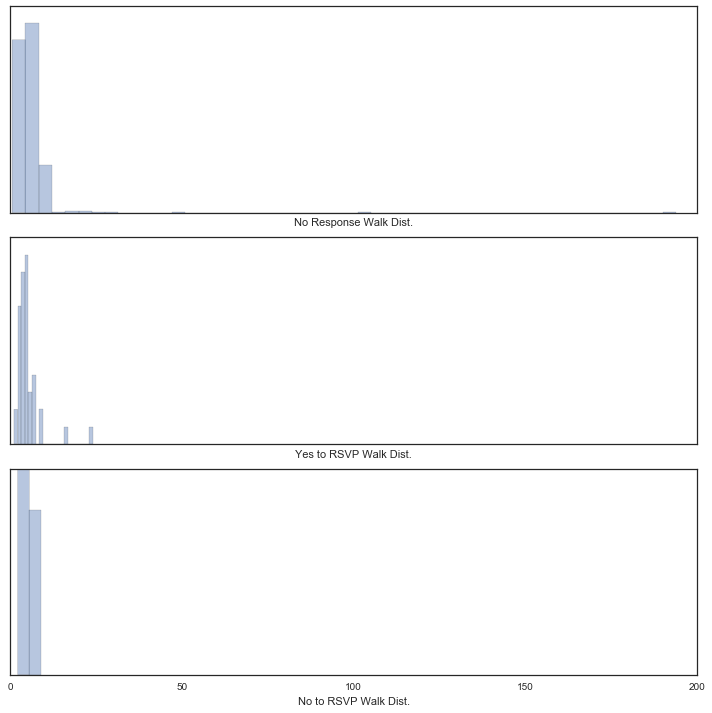

In [4]:
#looking at distributions, can see some serious outliers
f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
walk_dist = tot_sent_txt[['Clean_Response','walking_distance']].dropna()
walk_dist = walk_dist.loc[(walk_dist['walking_distance']>0)]
sns.distplot(walk_dist.loc[(walk_dist['Clean_Response']=='No Response')]['walking_distance'],
             ax=axes[0],axlabel='No Response Walk Dist.',kde=False);
sns.distplot(walk_dist.loc[(walk_dist['Clean_Response']=='Y')]['walking_distance'],
             ax=axes[1],axlabel='Yes to RSVP Walk Dist.',kde=False);
sns.distplot(walk_dist.loc[(walk_dist['Clean_Response']=='N')]['walking_distance'],
             ax=axes[2],axlabel='No to RSVP Walk Dist.',kde=False);
plt.setp(axes, yticks=[])
plt.tight_layout()

In [5]:
#seperating the distance and duration columns for each transportation mode
dist_keys = [col for col in rsvp_df if col.endswith('_distance')]
dur_keys = [col for col in rsvp_df if col.endswith('_duration')]
#turn original data into long format
melt_tot_txt = pd.melt(tot_sent_txt, id_vars='Clean_Response', value_vars=dur_keys+dist_keys,
                       var_name='Transit_Mode', value_name='Quant')
melt_tot_txt.dropna(inplace=True)

#removes invalid travel times
melt_tot_txt = melt_tot_txt.loc[melt_tot_txt['Quant']>0]

def outlierRem(df,varcol1,varcol2,filterCol):
    #get combinations of Responses w/ TransitType. Can then iterate to find outliers for each group
    group_types = [df[varcol1].unique(),df[varcol2].unique()]
    group_types = list(itertools.product(*group_types))
    #will contain filtered data as melt_tot_txt removes the outliers
    filtered_data = []
    for i in group_types:
        #selects frame by response type and transit
        group_select = (df[varcol1]==i[0])&(df[varcol2]==i[1])
        temp_df = df.loc[(group_select)]
        prior_count = len(temp_df[filterCol])
        #finds 1st quartile and 3rd quartile, then filters out vals outside of boundary
        Q1, Q3 = np.percentile(temp_df[filterCol],q=[25,75])
        IQR = Q3-Q1
        low_bound = Q1-IQR*1.5
        upper_bound = Q3+IQR*1.5
        temp_df = temp_df.loc[((group_select)&
                                (df[filterCol]>low_bound)&
                                (df[filterCol]<upper_bound))]
        post_count = len(temp_df[filterCol])
        print(str(i)+" Outlier Count: " +str(prior_count-post_count))
        filtered_data.append(temp_df)
    compo = pd.concat(filtered_data)
    return compo

tot_txt_xout = outlierRem(melt_tot_txt,'Clean_Response','Transit_Mode','Quant')
#splits frame by either distance frame and duration frame
dur_tot_txt = tot_txt_xout.loc[tot_txt_xout['Transit_Mode'].isin(dur_keys)].copy()
dur_tot_txt.rename(columns={'Quant':'Duration_min'},inplace=True)
dist_tot_txt = tot_txt_xout.loc[tot_txt_xout['Transit_Mode'].isin(dist_keys)].copy()
dist_tot_txt.rename(columns={'Quant':'Distance_km'},inplace=True)

('No Response', 'bicycling_duration') Outlier Count: 14
('No Response', 'driving_duration') Outlier Count: 7
('No Response', 'transit_duration') Outlier Count: 24
('No Response', 'walking_duration') Outlier Count: 14
('No Response', 'bicycling_distance') Outlier Count: 13
('No Response', 'driving_distance') Outlier Count: 84
('No Response', 'transit_distance') Outlier Count: 17
('No Response', 'walking_distance') Outlier Count: 13
('N', 'bicycling_duration') Outlier Count: 0
('N', 'driving_duration') Outlier Count: 0
('N', 'transit_duration') Outlier Count: 0
('N', 'walking_duration') Outlier Count: 0
('N', 'bicycling_distance') Outlier Count: 0
('N', 'driving_distance') Outlier Count: 1
('N', 'transit_distance') Outlier Count: 0
('N', 'walking_distance') Outlier Count: 0
('Y', 'bicycling_duration') Outlier Count: 1
('Y', 'driving_duration') Outlier Count: 0
('Y', 'transit_duration') Outlier Count: 1
('Y', 'walking_duration') Outlier Count: 3
('Y', 'bicycling_distance') Outlier Count: 

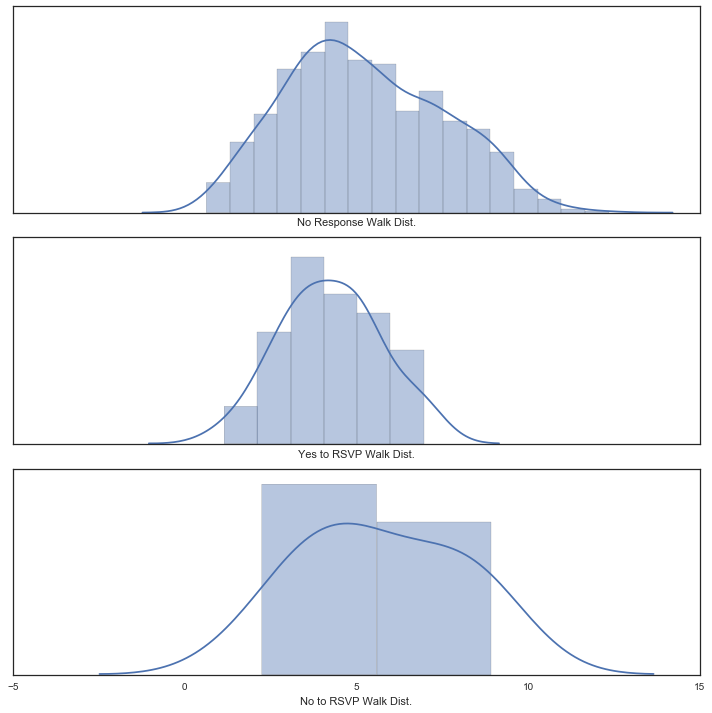

In [6]:
f, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
walk_dist_xout = dist_tot_txt.loc[dist_tot_txt['Transit_Mode']=='walking_distance'].copy()

sns.distplot(walk_dist_xout.loc[(walk_dist_xout['Clean_Response']=='No Response')]['Distance_km'],
             ax=axes[0],axlabel='No Response Walk Dist.');
sns.distplot(walk_dist_xout.loc[(walk_dist_xout['Clean_Response']=='Y')]['Distance_km'],
             ax=axes[1],axlabel='Yes to RSVP Walk Dist.');
sns.distplot(walk_dist_xout.loc[(walk_dist_xout['Clean_Response']=='N')]['Distance_km'],
             ax=axes[2],axlabel='No to RSVP Walk Dist.');
plt.setp(axes, yticks=[])
plt.tight_layout()

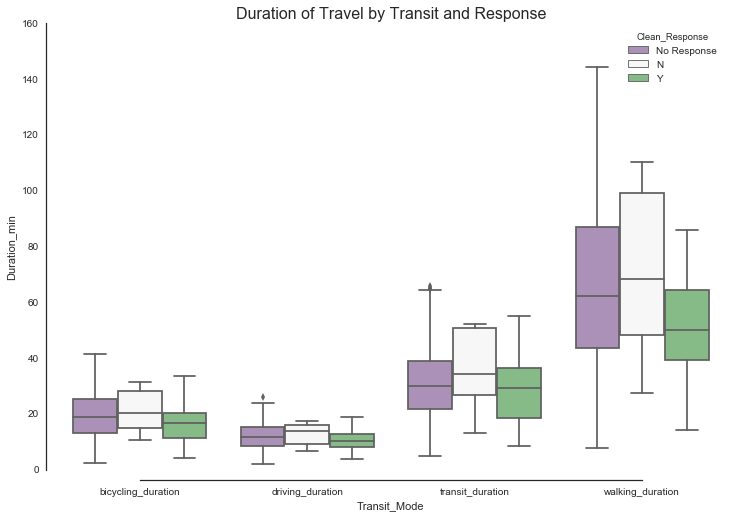

In [7]:
#boxplot of duration of travel by type of transit and by group
sns.boxplot(x='Transit_Mode',y="Duration_min",hue="Clean_Response",data=dur_tot_txt,
            palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.title('Duration of Travel by Transit and Response',fontsize=16)

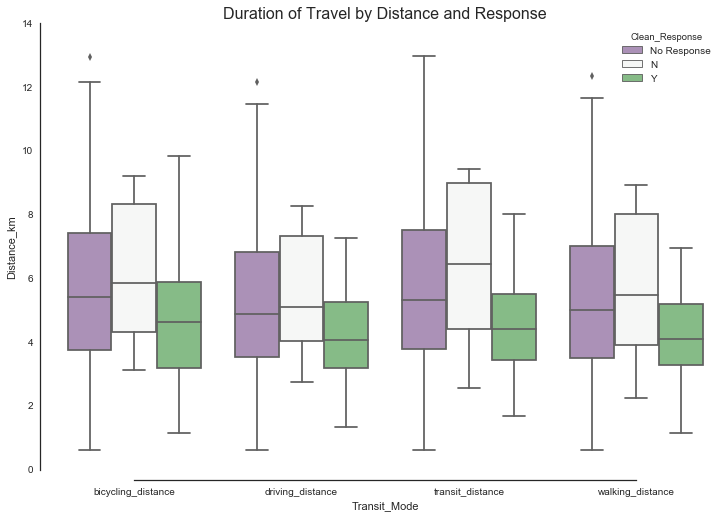

In [8]:
#boxplot of distance traveled times by type of transit and response group
sns.boxplot(x='Transit_Mode',y="Distance_km",hue="Clean_Response",data=dist_tot_txt,
            palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.title('Duration of Travel by Distance and Response', fontsize=16)

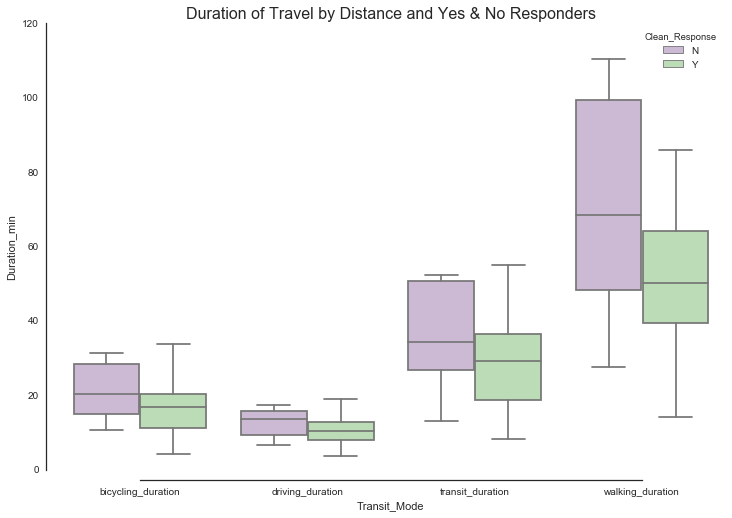

In [9]:
#Compare responders distances by group
dur_responders = dur_tot_txt.loc[dur_tot_txt["Clean_Response"].isin(['Y','N'])]
sns.boxplot(x="Transit_Mode", y="Duration_min", hue="Clean_Response", data=dur_responders, palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.title('Duration of Travel by Distance and Yes & No Responders', fontsize=16)

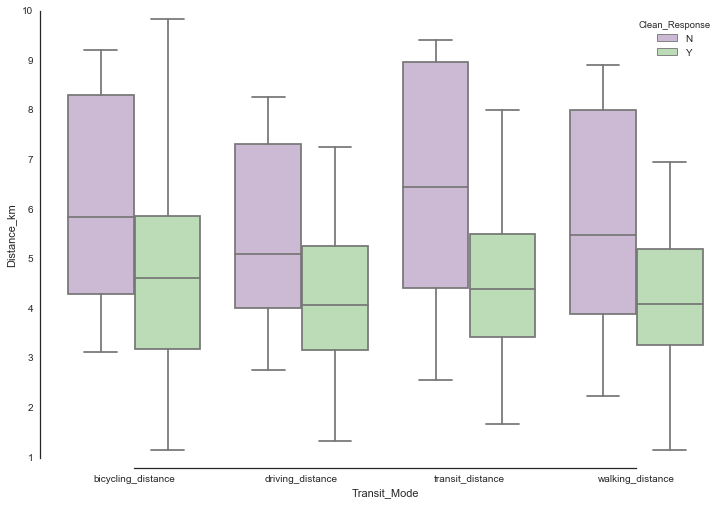

In [10]:
#Compare responders distances by group
dist_responders = dist_tot_txt.loc[dist_tot_txt["Clean_Response"].isin(['Y','N'])]
sns.boxplot(x="Transit_Mode", y="Distance_km", hue="Clean_Response", data=dist_responders, palette="PRGn")
sns.despine(offset=10, trim=True)

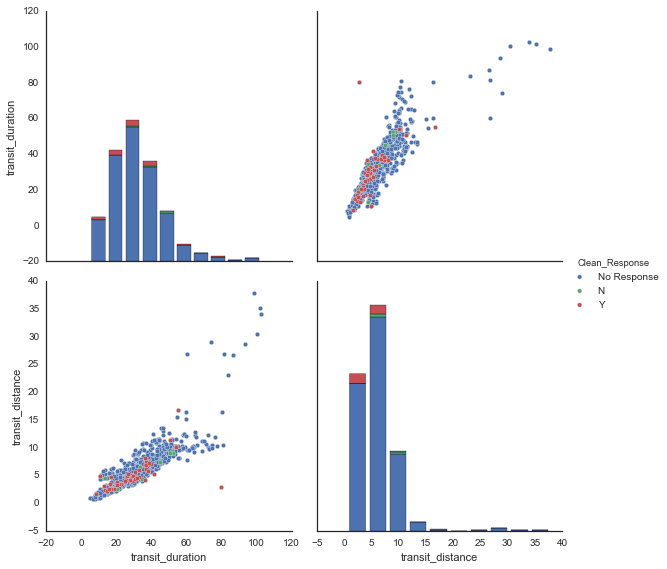

In [11]:
#pairwise plot w/ outliers back in ~boring
small = tot_sent_txt.loc[tot_sent_txt['Clean_Response'].isin(['Y','N','No Response'])]
small = small[['Clean_Response','transit_duration','transit_distance']]
small = small.loc[(small['transit_distance']<40)&(small['transit_distance']>0)]
sns.pairplot(small, hue="Clean_Response",size=4)

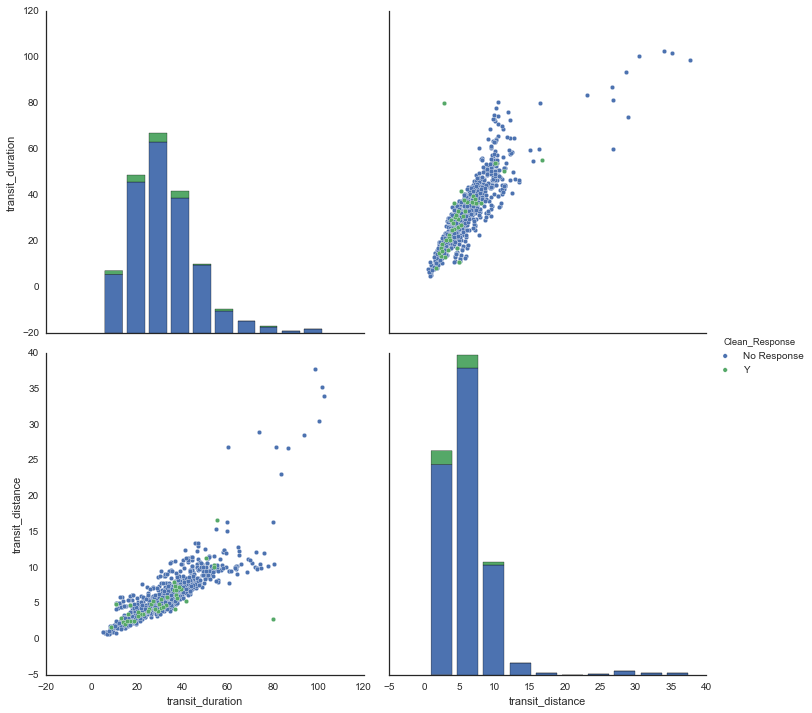

In [12]:
#pairwise plot ~boring
small = tot_sent_txt.loc[tot_sent_txt['Clean_Response'].isin(['Y','No Response'])]
small = small[['Clean_Response','transit_duration','transit_distance']]
small = small.loc[(small['transit_distance']<40)&(small['transit_distance']>0)]
sns.pairplot(small, hue="Clean_Response",size=5)

In [13]:
#(3) For the max one-way public transit time for the patients that showed up, 
#how many of the patients in the population at large have a public transit time 
#less than or equal to the max one-way time from (2)? Using RSVP for proxy

y_responder = dur_tot_txt.loc[(dur_tot_txt['Transit_Mode']=='transit_duration')&
                               (dur_tot_txt['Clean_Response']=='Y')]

In [14]:
y_responder_lng_dur = y_responder['Duration_min'].max()
y_responder_lng_dur

55.083333330000002

In [16]:
#Select contacts that are within our texted pop. and groupby type of contact
trim_contact = contact.loc[contact['PatientID'].isin(tot_sent_txt.index)]
trim_contact_cnt = trim_contact.groupby(['PatientID','ContactTypeSuccess'],as_index=False).count()
trim_contact_cnt = trim_contact_cnt.pivot(index='PatientID',columns='ContactTypeSuccess',values='MedicaidNum')
trim_contact_cnt.fillna(0,inplace=True)
tot_sent_txt = pd.merge(tot_sent_txt,trim_contact_cnt,right_index=True,left_index=True)
tot_sent_txt = pd.merge(tot_sent_txt,demography,left_index=True,right_on='PatientID')

In [17]:
ct_key = ['Successful Home Visit','Successful Phone Contact',
               'Unsuccessful Home Visit','Unsuccessful Phone Contact']

contact_melt = pd.melt(tot_sent_txt, id_vars='Clean_Response', value_vars=ct_key,
                       var_name='Contact_Type', value_name='Contact_Count')

contact_melt_xout = outlierRem(contact_melt,"Clean_Response",'Contact_Type','Contact_Count')

('No Response', 'Successful Home Visit') Outlier Count: 61
('No Response', 'Successful Phone Contact') Outlier Count: 95
('No Response', 'Unsuccessful Home Visit') Outlier Count: 25
('No Response', 'Unsuccessful Phone Contact') Outlier Count: 39
('N', 'Successful Home Visit') Outlier Count: 0
('N', 'Successful Phone Contact') Outlier Count: 0
('N', 'Unsuccessful Home Visit') Outlier Count: 9
('N', 'Unsuccessful Phone Contact') Outlier Count: 0
('Y', 'Successful Home Visit') Outlier Count: 7
('Y', 'Successful Phone Contact') Outlier Count: 5
('Y', 'Unsuccessful Home Visit') Outlier Count: 3
('Y', 'Unsuccessful Phone Contact') Outlier Count: 3


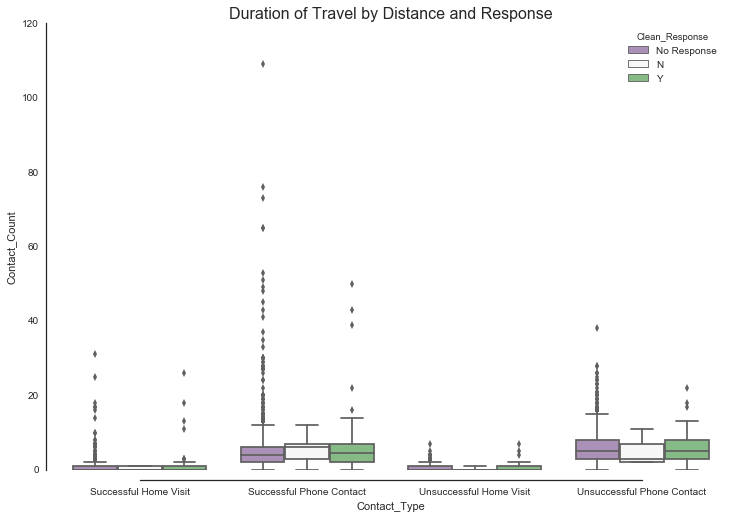

In [18]:
#boxplot of distance traveled times by type of transit and response group
sns.boxplot(x='Contact_Type',y="Contact_Count",hue="Clean_Response",data=contact_melt,
            palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.title('Text Responders', fontsize=16)

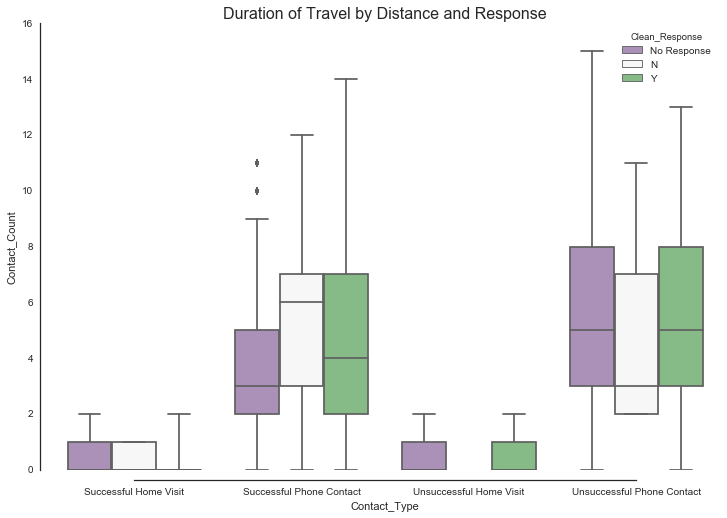

In [19]:
sns.boxplot(x='Contact_Type',y="Contact_Count",hue="Clean_Response",data=contact_melt_xout,
            palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.title('Duration of Travel by Distance and Response', fontsize=16)

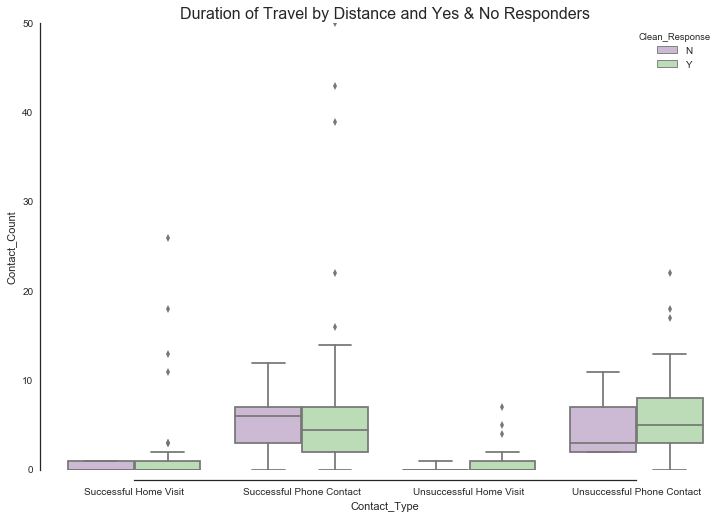

In [20]:
#Compare responders distances by group
contact_responders = contact_melt.loc[contact_melt["Clean_Response"].isin(['Y','N'])]
sns.boxplot(x="Contact_Type", y="Contact_Count", hue="Clean_Response", data=contact_responders, palette="PRGn")
sns.despine(offset=10, trim=True)
sns.plt.title('Duration of Travel by Distance and Yes & No Responders', fontsize=16)